<a href="https://colab.research.google.com/github/migonzalez0310/RobotTrading_Challenge/blob/main/RobotTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Robot Trading - 1er Challenge** 🤖
**Creado por Miguel Gonzalez**

## **1) Configuración del ambiente y Creación de variables globales**





In [18]:
#Importar las librerias que usaremos para el challenge
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import requests
from bs4 import BeautifulSoup
from IPython.display import clear_output
import time

#Creacion de las variables globales
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

## **2) Obtención de datos**

*Crearemos la función importar_base_bitcoin() usando la biblioteca yfinance para obtener el historial de precios del Bitcoin en dólares (BTC-USD) de los últimos 7 días en intervalos de 5 minutos, almacenándolo en el dataframe df_bitcoin y redefiniendo variables globales.*

In [ ]:
def importar_base_bitcoin():
  #Definiendo variables globales en la funcion
  global df_bitcoin
  #Definiendo moneda a buscar
  moneda ='BTC-USD'
  df_bitcoin = yf.download(moneda, period='7d', interval='5m')
  return df_bitcoin

*La función extraer_tendencias() realiza Web Scraping en CoinMarketCap para obtener el precio actual del Bitcoin en USD y su variación en la última hora. Almacena el precio como float en precio_actual y determina la tendencia si es Alta o Baja y la variacion en la ultima hora*

In [ ]:
def extraer_tendencias():
        #Definiendo variables globales en la funcion
        global  precio_actual, tendencia

        # Definir la URL de la página de CoinMarketCap
        url = 'https://coinmarketcap.com/'

        # Realizar la solicitud GET a la página
        response = requests.get(url)

        # Verificar si la solicitud fue exitosa
        if response.status_code == 200:
            # Parsear el contenido HTML de la página
            soup = BeautifulSoup(response.content, 'html.parser')

            # Encontrar el elemento que contiene el precio actual del Bitcoin
            bitcoin_price_element = soup.find('div', class_='sc-500f568e-0 ejtlWy')

            # Extraer el precio actual del Bitcoin y convertirlo a float
            precio_actual = float(bitcoin_price_element.text.strip().split("$")[1].replace(',', ''))

            # Encontrar el elemento que contiene la variación de precio en la última hora
            price_change_element = soup.find('span', class_='sc-6a54057-0 YXxPZ')

            # Extraer la variación de precio en la última hora
            variacion_1h = float(price_change_element.text.strip().split("%")[0])

            alta = soup.find('span', class_='icon-Caret-up')
            baja = soup.find('span', class_='icon-Caret-down')

            # Determinar la tendencia
            if 'icon-Caret-up' in alta.attrs['class']:
              tendencia = "Alta"
            else:
              tendencia = "Baja"

            # Devolver el precio actual y la tendencia
            return precio_actual, tendencia, variacion_1h
        else:
            print("Error al conectar con la página")
            return None, None,None

Precio actual del Bitcoin: 67832.53
Tendencia: alta
Variacion_1H: 0.22


##**3) Limpieza de datos 🧹**



La función limpieza_datos() crea una copia de df_bitcoin llamada df_bitcoin_limpio y realiza varias tareas de limpieza:

1.   Elimina duplicados en el índice.
1.   Trata los valores nulos en la columna Close.
2.   Elimina registros con Volumen de transacción igual a 0.
2.   Elimina outliers en el precio del Bitcoin usando un boxplot.
1.   Filtra registros cuyo precio está entre el 1er y 3er cuartil del boxplot.
2.   Calcula el precio promedio (Close) de la selección y lo guarda en media_bitcoin.





In [16]:
def limpieza_datos():
    # Definiendo variables globales en la función
    global df_bitcoin, media_bitcoin
    df_bitcoin_limpio = importar_base_bitcoin()

    # Eliminando los duplicados basados en el índice
    df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated()]

    # Tratando los datos nulos
    # Buscar valores nulos en la columna "Close"
    valores_nulos = df_bitcoin_limpio['Close'].isnull()

    # Calcular el valor medio de la columna "Close"
    valor_medio_close = df_bitcoin_limpio['Close'].mean()

    # Rellenar los valores nulos con el valor medio de "Close"
    # df_bitcoin_limpio['Close'].fillna(valor_medio_close", inplace=True)

    # Rellenar los valores nulos con el valor anterior de "Close"
    df_bitcoin_limpio['Close'].fillna(method='bfill', inplace=True)


    # Volumen de transacción > 0
    # Crear una máscara booleana para identificar filas con volumen de transacción igual a 0
    mascara = df_bitcoin_limpio['Volume'] == 0

    # Eliminar las filas donde el volumen de transacción es igual a 0
    df_bitcoin_limpio = df_bitcoin_limpio.loc[~mascara]

    # Identificar y eliminar outliers en el precio del Bitcoin (columna Close)
    Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
    Q3 = df_bitcoin_limpio['Close'].quantile(0.75)
    # IQR = Q3 - Q1

    # # Definir límites para identificar outliers
    # lower_bound = Q1 - 1.5 * IQR
    # upper_bound = Q3 + 1.5 * IQR

    # Filtrar outliers
    df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= Q1) & (df_bitcoin_limpio['Close'] <= Q3)]

    # Graficar boxplot para identificar outliers
    plt.figure(figsize=(8, 6))
    plt.boxplot(df_bitcoin_limpio['Close'], vert=True)
    plt.title('Boxplot del Precio del Bitcoin')
    plt.xlabel('Precio del Bitcoin')
    plt.show()

    # Filtrar registros cuyo precio (Close) se encuentre entre el 1er cuartil (Q1) y el 3er cuartil (Q3)
    df_seleccion = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= Q1) & (df_bitcoin_limpio['Close'] <= Q3)]

    # Calcular el precio promedio (Close) de esta selección
    media_bitcoin = df_seleccion['Close'].mean()

    return df_bitcoin_limpio, media_bitcoin

## **4) Tomar decisiones**

La función tomar_decisiones() determina la variable algoritmo_decision con base en un criterio de decisión:

1. Si el precio actual es mayor o igual al precio promedio y la tendencia es baja, algoritmo_decision será 'Vender'.

2. Si el precio actual es menor que el precio promedio y la tendencia es alta, algoritmo_decision será 'Comprar'.

1. Si ninguna de las condiciones anteriores se cumple, algoritmo_decision será 'Esperar'.



In [ ]:
def tomar_decisiones():
  # Definiendo variables globales en la función
  global precio_actual, tendencia, media_bitcoin, algoritmo_decision

  if precio_actual >= media_bitcoin and tendencia == "Baja":
    algoritmo_decision = 'Vender'
  elif precio_actual < media_bitcoin and tendencia == "Alta":
    algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = 'Esperar'

  return algoritmo_decision

## **5) Visualización**

La función visualizacion() agrega una columna "Promedio" al dataframe original df_bitcoin con el valor de media_bitcoin, configura el tamaño del gráfico a 16x5, agrega un título, traza una línea con los datos del índice y Close, otra con los datos del índice y Promedio, muestra un mensaje con la decisión del algoritmo usando annotate(), y muestra el gráfico en pantalla con show().








In [ ]:
def visualizacion():
    # Definir variables globales
    global df_bitcoin, media_bitcoin, algoritmo_decision

    # Agregar nueva columna "Promedio" al DataFrame original df_bitcoin
    df_bitcoin['Promedio'] = media_bitcoin

    # Configurar el tamaño del gráfico
    plt.figure(figsize=(16, 5))

    # Dibujar línea con los datos del índice y la columna "Close" de df_bitcoin
    plt.plot(df_bitcoin.index, df_bitcoin['Close'], label='Precio de Bitcoin (Close)')

    # Dibujar línea con los datos del índice y la columna "Promedio" de df_bitcoin
    plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], label='Promedio', linestyle='--')

    # Configurar título y etiquetas de los ejes
    plt.title('Precio del Bitcoin vs Promedio')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')

    # Mostrar mensaje con la decisión calculada del algoritmo
    color = 'green' if algoritmo_decision == 'Vender' else 'blue' if algoritmo_decision == 'Comprar' else 'red'
    plt.annotate(algoritmo_decision, xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(-30, 50),
                 textcoords='offset points', arrowprops=dict(facecolor=color, arrowstyle='->', connectionstyle='arc3,rad=.5'),
                 fontsize=12, color=color, horizontalalignment='center', zorder=5)

    # Mostrar leyenda
    plt.legend()

    # Mostrar el gráfico
    plt.show()


## **Automatización**

Importa 'clear_output()' de 'IPython.display' para borrar resultados previos antes de imprimir un nuevo gráfico, y 'time' para pausar la ejecución del código cada 5 minutos. Luego, crea un bucle infinito que ejecuta las funciones importar_base_bitcoin(), extraer_tendencias(), limpieza_datos(), tomar_decisiones() y visualizacion() en intervalos de 5 minutos con time.sleep(300). Esto proporciona un gráfico en tiempo real del historial de precios del Bitcoin y la decisión del algoritmo.








[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


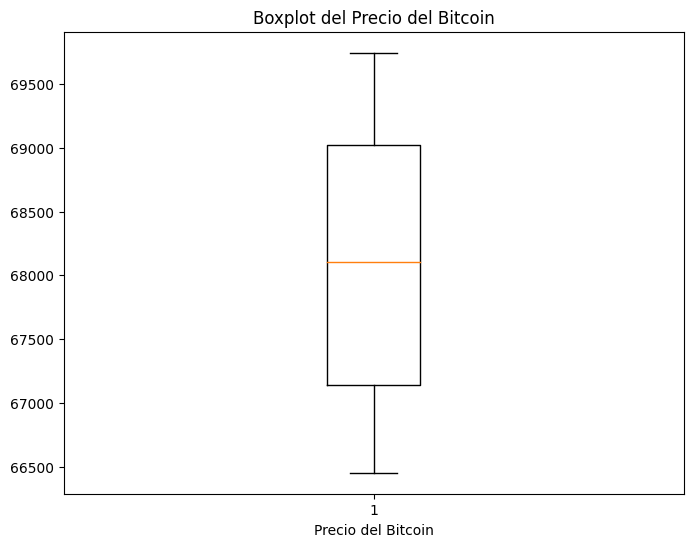

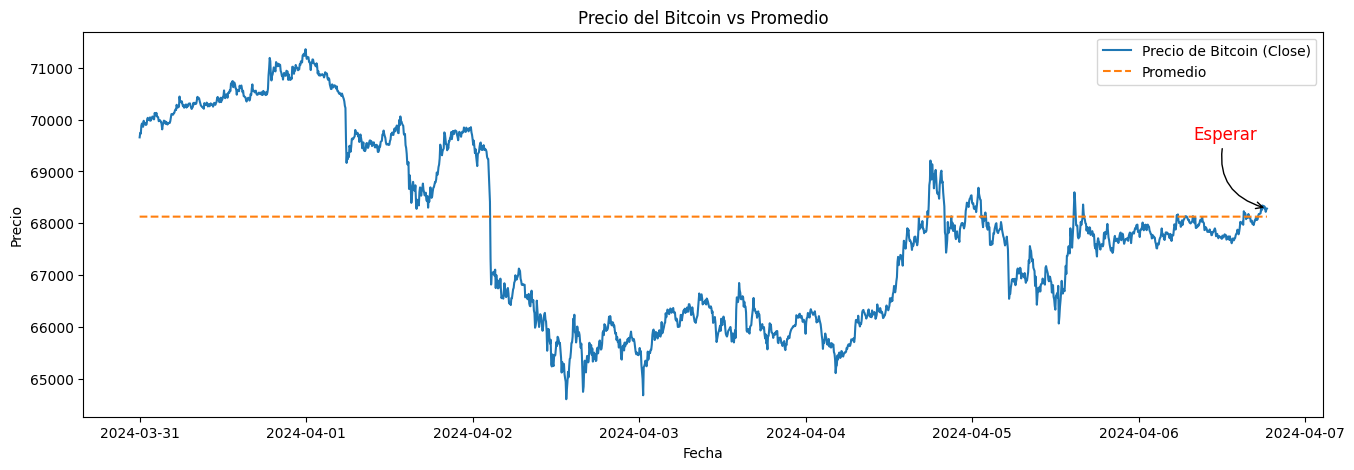

In [ ]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(60)